In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt

from functions import logLjoint2_skew, estimate_Jacobian

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import skewnorm

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=18)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF_updated.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
# ra,dec,z
ra = np.array(catalog_main['RA'])
dec = np.array(catalog_main['DEC'])
z = np.array(catalog_main['Z'])

#stellar mass
#Mstar = np.array(data['Mstar'])
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])

# color
#u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 
u_r_NSA = np.array(catalog_main['u_r'])

#g_r = np.array(data['g_r'])
g_r_NSA = np.array(catalog_main['g_r'])

# absolute magnitude
#rabsmag = np.array(data['rabsmag'])
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])

# star formation rate and specific SPR
#SFR = np.array(data['SFR'])
SFR  = np.array(catalog_main['SFR'])

#sSFR = np.array(data['sSFR'])
sSFR = np.array(catalog_main['sSFR'])

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_31829/3799946246.py:8: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])


## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0 #np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = catalog_main['vflag_V2'] == 1 #np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = catalog_main['vflag_V2'] == 2 #np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = catalog_main['vflag_V2'] == 9 #np.argwhere(data['flag_vsquared'] == 9).flatten()

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0 #np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = catalog_main['vflag_VF'] == 1 #np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = catalog_main['vflag_VF'] == 2 #np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = catalog_main['vflag_VF'] == 9 #np.argwhere(data['flag_voidfinder'] == 9).flatten()

# Fit the distributions with skewnormal distributions

In [8]:
################################################################################
#-------------------------------------------------------------------------------
"""
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
"""

def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
################################################################################




################################################################################
#-------------------------------------------------------------------------------
"""
def func_unimodal(x, a, mua, sga, askew):
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga)
"""

def func_unimodal(x, a, mu, sg, skew):
    """
    One skew normal distribution
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a : float
        amplitude of the skew normal distribution
        
    mu : float
        location of the skew normal distribution
        
    sg : float
        width of the skew normal distribution
        
    skew : float
        skew of the skew normal distribution
    

    Returns
    -------
    model : float or ndarray
        Model evaluated at x.
    """

    return a*skewnorm.pdf(x, skew, loc=mu, scale=sg)
################################################################################

In [9]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [10]:
def fit_bimodal(char_, class_, bins, p0_=None, err=None, label=''):
    
    x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = np.sqrt(y_data)
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    #s = dy
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    return popt_, np.sqrt(np.diag(pcov_))

In [11]:
def fit_unimodal(char_, class_, bins, p0_=None, err=None, label=''):
    
    x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)
    
    if err is None:
        err = np.sqrt(y_data)
    else:
        err[np.argwhere(err==0)] = 0.00001
        
    # Normalize by the total number of galaxies in the sample
    N = np.sum(y_data)
    y_data = y_data/N
    
    #s = dy
    
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err/N, fmt='.')  
    plt.plot(x_data, func_unimodal(x_data, *popt_), 'k') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.ylabel("Counts")
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_
    

## $M_*$ mean

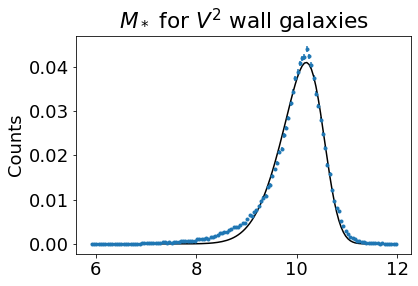

[ 0.04307047 10.52301832  0.66283669 -2.5134647 ] [0.00035561 0.00710778 0.01058374 0.12581298]


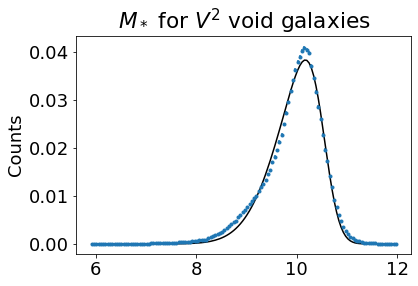

[ 0.04388553 10.53230876  0.75213752 -2.9551447 ] [0.00034889 0.00643558 0.0105299  0.13492495]


In [60]:
Mstar_bins = np.linspace(5.9, 12, 135)

#print("wall_v2")
x, n_V2_wall, poiss_err = bin_data(Mstar_NSA[wall_v2], bins_=Mstar_bins)
Mstar_NSA_V2_wall_fit = fit_unimodal(char_=Mstar_NSA,
                                     class_=wall_v2,
                                     bins=Mstar_bins, 
                                     err=poiss_err,
                                     p0_=[0.05, 10.5, 1.3, 1],#[ 2000,  10.5,  1.3, 1], 
                                     label='$M_*$ for $V^2$ wall galaxies')
'''
Mstar_NSA_V2_wall_chi2_curvefit = np.sum((n - func_unimodal(x, 
                                            *Mstar_NSA_V2_wall_fit[0]))**2/poiss_err**2)
Mstar_NSA_V2_wall_chi2_minimize = np.sum((n - func_unimodal(x, 
                                            4639.52, 
                                            10.61, 
                                            0.93, 
                                            -3.38))**2/poiss_err**2)
print(Mstar_NSA_V2_wall_chi2_curvefit/4)
print(Mstar_NSA_V2_wall_chi2_minimize/4)
''';
#print("\n void_v2")
x, n_V2_void, poiss_err = bin_data(Mstar_NSA[void_v2], bins_=Mstar_bins)
Mstar_NSA_V2_void_fit = fit_unimodal(char_=Mstar_NSA, 
                                     class_=void_v2,
                                     bins=Mstar_bins, 
                                     err=poiss_err,
                                     p0_=[0.05, 10.5, 1.3, 1],#[ 2000,  10.5,  1.3, 1], 
                                     label='$M_*$ for $V^2$ void galaxies')

In [53]:
def fit_uncertainty(fit, cov, x):
    '''
    Calculate the uncertainty at each point in x for the fit.
    
    
    PARAMETERS
    ==========
    
    fit : list of length n
        Values of the best-fit parameters for the skew-normal fit
        
    cov : ndarray of shape (n,n)
        Covariance matrix corresponding to the n best-fit parameters.
        
    x : ndarray of shape (m,) or (,m)
        The x positions at which the best-fit function is evaluated.
        
    
    RETURNS
    =======
    
    df : ndarray of shape (m,) or (,m)
        Uncertainty in the best-fit value at each x position.
    '''
    
    # Initialize the Jacobian matrix for x
    Jf = np.zeros((len(x), cov.shape[0]))
    
    # Estimate the Jacobian of the best-fit function at x
    for i in range(len(x)):
        Jf[i,:] = estimate_Jacobian(func_unimodal, x[i], fit)
        
    # Calculate the uncertainty of the best-fit function at x
    df = Jf@cov@Jf.T
    
    return np.diagonal(df)


def fit_uncertainty_approx(fit, cov, x):
    '''
    Estimate the uncertainty at each point in x for the fit.
    
    
    PARAMETERS
    ==========
    
    fit : list of length n
        Values of the best-fit parameters for the skew-normal fit
        
    cov : ndarray of shape (n,n)
        Covariance matrix corresponding to the n best-fit parameters.
        
    x : ndarray of shape (m,) or (,m)
        The x positions at which the best-fit function is evaluated.
        
    
    RETURNS
    =======
    
    df : ndarray of shape (m,) or (,m)
        Uncertainty in the best-fit value at each x position.
    '''
    
    # Generate a large number of random samples of the best-fit parameters
    random_params = np.random.default_rng().multivariate_normal(fit, cov, 5000).T
    
    stddev = np.zeros(x.shape)
    
    for i in range(len(x)):
        
        # Calculate the value of the function at x for each of these parameter sets
        f = func_unimodal(x[i], random_params[0], random_params[1], random_params[2], random_params[3])
        
        stddev[i] = np.std(f)
    
    return stddev

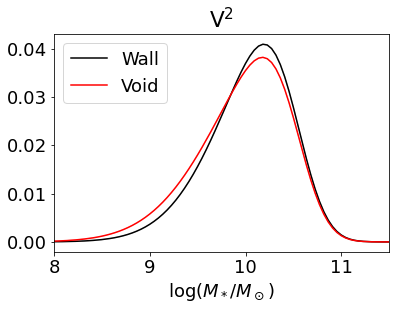

In [63]:
plt.figure()

wall_fit = func_unimodal(Mstar_bins, *Mstar_NSA_V2_wall_fit[0])#/Mstar_NSA_V2_wall_fit[0][0]
void_fit = func_unimodal(Mstar_bins, *Mstar_NSA_V2_void_fit[0])#/Mstar_NSA_V2_void_fit[0][0]

wall_uncertainty = fit_uncertainty(Mstar_NSA_V2_wall_fit[0], Mstar_NSA_V2_wall_fit[1], Mstar_bins)#/Mstar_NSA_V2_wall_fit[0][0]
void_uncertainty = fit_uncertainty(Mstar_NSA_V2_void_fit[0], Mstar_NSA_V2_void_fit[1], Mstar_bins)#/Mstar_NSA_V2_void_fit[0][0]
#wall_uncertainty = fit_uncertainty_approx(Mstar_NSA_V2_wall_fit[0], Mstar_NSA_V2_wall_fit[1], Mstar_bins)#/Mstar_NSA_V2_wall_fit[0][0]
#void_uncertainty = fit_uncertainty_approx(Mstar_NSA_V2_void_fit[0], Mstar_NSA_V2_void_fit[1], Mstar_bins)#/Mstar_NSA_V2_void_fit[0][0]

plt.plot(Mstar_bins, wall_fit, 'k', label='Wall')
plt.fill_between(Mstar_bins, 
                 wall_fit + wall_uncertainty, 
                 wall_fit - wall_uncertainty, 
                 color='k', 
                 alpha=0.1)

plt.plot(Mstar_bins, void_fit, 'r', label='Void')
plt.fill_between(Mstar_bins, 
                 void_fit + void_uncertainty, 
                 void_fit - void_uncertainty, 
                 color='r', 
                 alpha=0.1)

plt.xlim((8,11.5))

plt.xlabel('log($M_*/M_\odot$)')
#plt.ylabel('number of galaxies')

plt.title('V$^2$')

plt.legend(loc='upper left');

In [31]:
'''
pars = np.concatenate([Mstar_NSA_V2_wall_fit[0], Mstar_NSA_V2_void_fit[0]])
logLjoint2_skew(pars, n_V2_wall, n_V2_void, x, 1)
''';

-25819.251841096724

In [32]:
'''
pars = [4639.75, 10.62, 0.93, -3.40, 10623.76, 10.61, 0.93, -3.37]
logLjoint2_skew(pars, n_V2_wall, n_V2_void, x, 1)
''';

-9973.66783867604

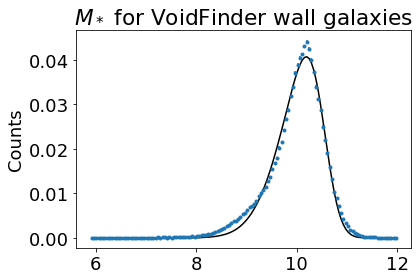

[ 0.04367414 10.53264785  0.67790361 -2.53389391] [0.00035194 0.00702347 0.01051065 0.12336392]


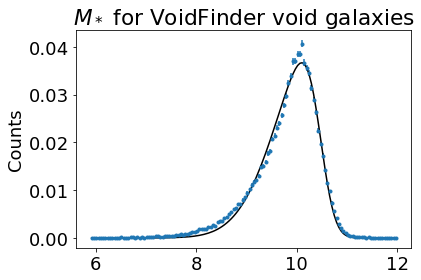

[ 0.04391638 10.46432345  0.80940424 -3.40845906] [0.00034023 0.00585077 0.01030861 0.14803342]


In [65]:
#print("\n wall_vf")
k = bin_data(Mstar_NSA[wall_vf], bins_=Mstar_bins)
x, poiss_err = k[0], k[2]
Mstar_NSA_VF_wall = fit_unimodal(char_=Mstar_NSA,
                                 class_=wall_vf,
                                 bins=Mstar_bins, 
                                 err=poiss_err,
                                 p0_=[0.05, 10.5, 1.3, 1], #[ 2000,  10.5,  1.3, 1], 
                                 label='$M_*$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(Mstar_NSA[void_vf], bins_=Mstar_bins)
x, poiss_err = k[0], k[2]
Mstar_NSA_VF_void = fit_unimodal(char_=Mstar_NSA,
                                 class_=void_vf,
                                 bins=Mstar_bins, 
                                 err=poiss_err,
                                 p0_=[0.05, 10.5, 1.3, 1], #[ 2000,  10.5,  1.3, 1], 
                                 label='$M_*$ for VoidFinder void galaxies')

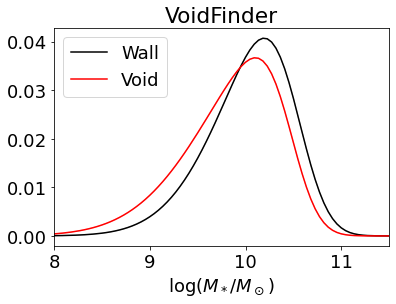

In [66]:
plt.figure()

wall_fit = func_unimodal(Mstar_bins, *Mstar_NSA_VF_wall[0])#/Mstar_NSA_VF_wall[0][0]
void_fit = func_unimodal(Mstar_bins, *Mstar_NSA_VF_void[0])#/Mstar_NSA_VF_void[0][0]

wall_uncertainty = fit_uncertainty(Mstar_NSA_VF_wall[0], Mstar_NSA_VF_wall[1], Mstar_bins)#/Mstar_NSA_VF_wall[0][0]
void_uncertainty = fit_uncertainty(Mstar_NSA_VF_void[0], Mstar_NSA_VF_void[1], Mstar_bins)#/Mstar_NSA_VF_void[0][0]

plt.plot(Mstar_bins, wall_fit, 'k', label='Wall')
plt.fill_between(Mstar_bins, 
                 wall_fit + wall_uncertainty, 
                 wall_fit - wall_uncertainty, 
                 color='k', 
                 alpha=0.1)

plt.plot(Mstar_bins, void_fit, 'r', label='Void')
plt.fill_between(Mstar_bins, 
                 void_fit + void_uncertainty, 
                 void_fit - void_uncertainty, 
                 color='r', 
                 alpha=0.1)

plt.xlim((8,11.5))

plt.xlabel('log($M_*/M_\odot$)')
#plt.ylabel('number of galaxies')

plt.title('VoidFinder')

plt.legend(loc='upper left');

## $M_r$ mean 

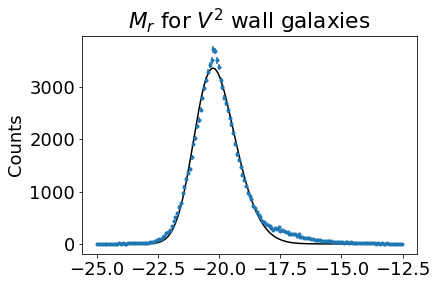

[ 7.13665807e+03 -2.08880831e+01  1.18900126e+00  1.64559018e+00] [5.49321711e+01 2.24202620e-02 2.46701388e-02 1.04816121e-01]


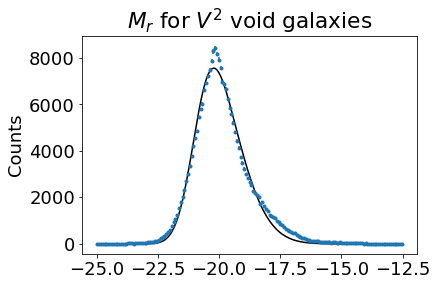

[ 1.75255762e+04 -2.09458885e+01  1.40072318e+00  2.14422291e+00] [1.35836010e+02 1.74634251e-02 2.34271132e-02 1.09757445e-01]


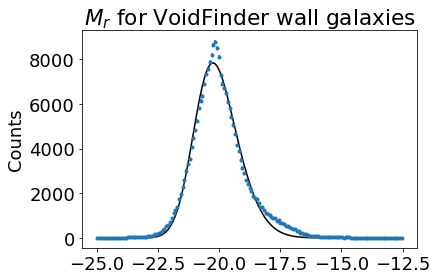

[ 1.72166632e+04 -2.09237989e+01  1.25681746e+00  1.76481061e+00] [1.36835939e+02 2.17360992e-02 2.52686588e-02 1.08182831e-01]


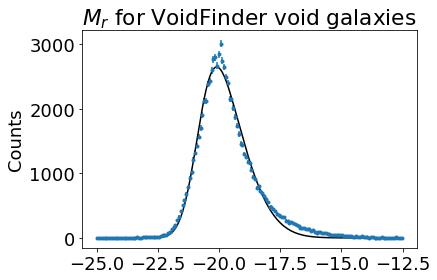

[ 6.10638340e+03 -2.08252247e+01  1.43860231e+00  2.41436257e+00] [4.96568406e+01 1.59934569e-02 2.32207236e-02 1.21247347e-01]


In [16]:
#print("wall_v2")
k = bin_data(rabsmag_NSA[wall_v2], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_V2_wall_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=wall_v2,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(rabsmag_NSA[void_v2], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_V2_void_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=void_v2,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(rabsmag_NSA[wall_vf], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_VF_wall_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=wall_vf,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(rabsmag_NSA[void_vf], bins_=np.linspace(-25,-12.5, 170))
x, poiss_err = k[0], k[2]
rabsmag_NSA_VF_void_fit = fit_unimodal(char_=rabsmag_NSA,
                                       class_=void_vf,
                                       bins=np.linspace(-25,-12.5, 170), 
                                       err=poiss_err,p0_=[ 2000,  -20,  1.3, 1], 
                                       label='$M_r$ for VoidFinder void galaxies')

## $u-r$ mean

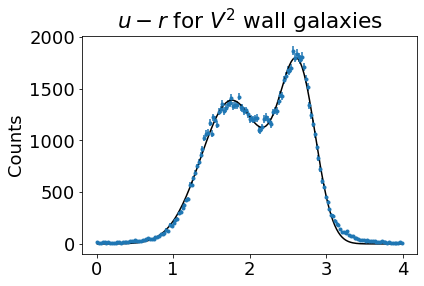

[ 1.37233582e+03  1.75887641e+00  3.96153150e-01  3.02439347e-03
  1.00351014e+03  2.77925700e+00  2.95429777e-01 -1.03070152e+00] [2.83372709e+01 1.49027274e+02 1.20754922e-01 4.71483830e+02
 2.55372293e+01 1.94658496e-02 1.92998250e-02 2.01960072e-01]


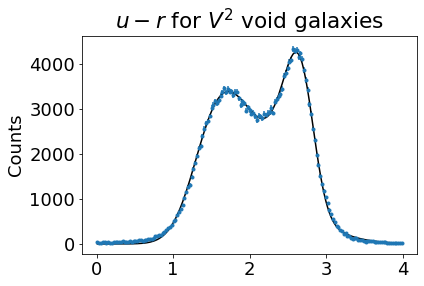

[ 4.14068301e+03  1.33564049e+00  7.88554077e-01  2.74986198e+00
  1.62940638e+03  2.78597259e+00  2.77398690e-01 -1.41865364e+00] [3.17285317e+01 3.77221425e-03 9.54365605e-03 7.00732677e-02
 2.47573904e+01 5.31784469e-03 5.93765697e-03 8.64507092e-02]


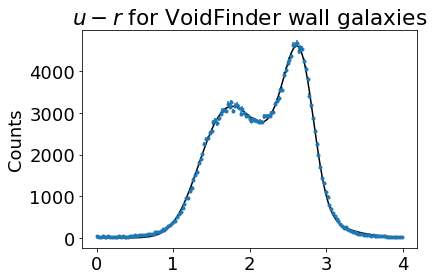

[ 1.79269778e+03  2.79307712e+00  2.77194170e-01 -1.44850825e+00
  3.91260220e+03  1.37407525e+00  7.92639064e-01  2.65563510e+00] [2.28752727e+01 4.60588899e-03 5.30717681e-03 7.84340903e-02
 2.98334541e+01 4.18272125e-03 9.30151097e-03 6.92884022e-02]


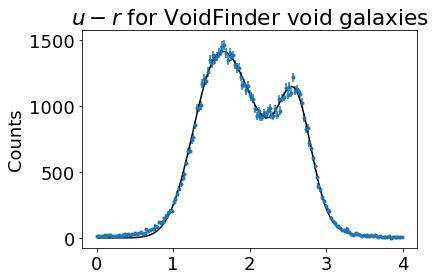

[1.58696222e+03 1.29555504e+00 7.02366369e-01 2.45966920e+00
 4.23458949e+02 2.54011077e+00 2.17901646e-01 3.68961387e-01] [2.07771160e+01 6.91270810e-03 1.87791570e-02 1.26852286e-01
 1.83551026e+01 1.24619408e-01 3.59347075e-02 8.25811657e-01]


In [17]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(u_r_NSA[wall_v2], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_V2_wall_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=wall_v2,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for $V^2$ wall galaxies')#,p0_=[ 2000,  1.5,  1.3, 1,2000,2.7,1,1])


#print("\n void_v2")
k = bin_data(u_r_NSA[void_v2], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_V2_void_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=void_v2,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 label='$u-r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(u_r_NSA[wall_vf], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_VF_wall_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=wall_vf,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err, 
                                 p0_=[1500,  2.8,  0.25, -1.5, 3500, 1.25, 0.75, 2.75],
                                 label='$u-r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(u_r_NSA[void_vf], bins_=np.linspace(0,4, 170))
x, poiss_err = k[0], k[2]
ur_NSA_VF_void_fit = fit_bimodal(char_=u_r_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(0,4, 170), 
                                 err=poiss_err,
                                 p0_=[2000,  1.5,  1.3, 1, 2000, 2.7, 1, 1], 
                                 label='$u-r$ for VoidFinder void galaxies')

## $g-r$ means

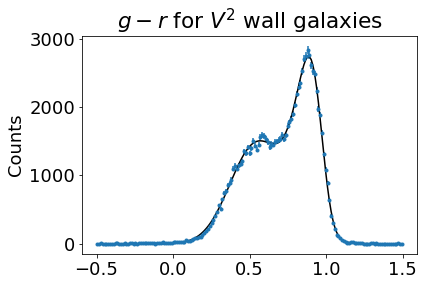

[ 5.31356570e+02  9.62912958e-01  1.30268944e-01 -2.00847915e+00
  6.77172172e+02  4.33122252e-01  2.28415467e-01  1.09611012e+00] [1.87842047e+01 1.60404829e-03 3.47772540e-03 1.03649014e-01
 2.04066275e+01 1.54834539e-02 1.80863845e-02 2.24670074e-01]


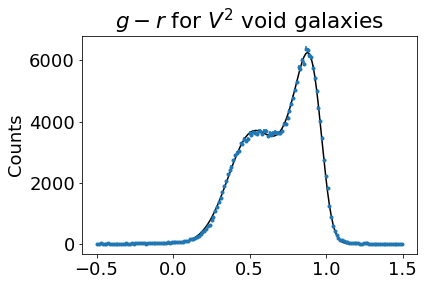

[ 1.52141110e+03  9.63398365e-01  1.59755287e-01 -2.56627476e+00
  1.38065722e+03  5.13986561e-01  1.55960684e-01 -9.50802196e-04] [2.50587942e+01 9.53412238e-04 3.49353732e-03 9.67336085e-02
 2.66624519e+01 1.09696736e+01 3.31178373e-03 8.81528149e+01]


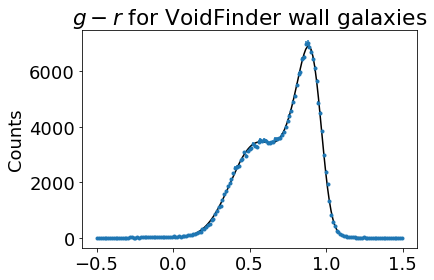

[ 1.48085128e+03  4.26440612e-01  2.25630960e-01  1.20742056e+00
  1.38892263e+03  9.61720895e-01  1.36550052e-01 -2.30969481e+00] [3.43766498e+01 8.82471108e-03 1.21370817e-02 1.51765103e-01
 3.19841282e+01 8.19788122e-04 2.22492385e-03 6.42414637e-02]


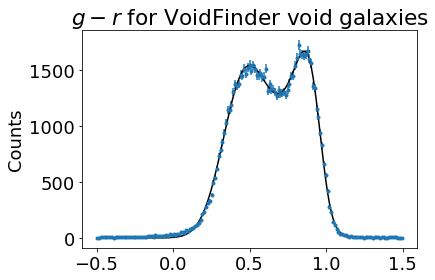

[ 3.55552175e+02  9.52877972e-01  1.55263914e-01 -2.31959977e+00
  6.59678429e+02  3.57750967e-01  2.47140820e-01  1.73433942e+00] [2.14710914e+01 2.06017603e-03 6.48089784e-03 1.39488386e-01
 2.25811089e+01 5.88889768e-03 1.47936957e-02 1.84110946e-01]


In [19]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(g_r_NSA[wall_v2], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_V2_wall_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=wall_v2,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 p0_=[563.67, 0.97, 0.14, -2.33, 701.15, 0.39, 0.24, 1.44], 
                                 label='$g-r$ for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(g_r_NSA[void_v2], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_V2_void_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=void_v2,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(g_r_NSA[wall_vf], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_VF_wall_fit = fit_bimodal(char_=g_r_NSA, 
                                 class_=wall_vf,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err, 
                                 label='$g-r$ for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(g_r_NSA[void_vf], bins_=np.linspace(-0.5,1.5, 170))
x, poiss_err = k[0], k[2]
gr_NSA_VF_void_fit = fit_bimodal(char_=g_r_NSA,
                                 class_=void_vf,
                                 bins=np.linspace(-0.5,1.5, 170), 
                                 err=poiss_err,
                                 p0_=np.array([ 8.85731778e+02,  9.84204392e-01,  8.07998114e-02, -3.33639653e+00, 1.39274659e+03,  4.75774665e-01,  2.82524710e-01,  1.32105068e+00]), 
                                 label='$g-r$ for VoidFinder void galaxies')

## SFR

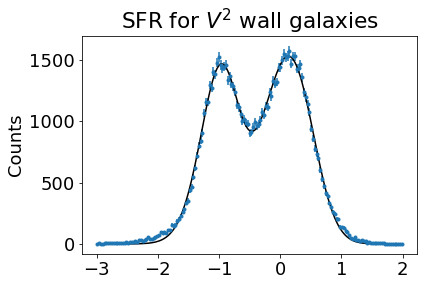

[ 1.64318660e+03  4.55660961e-01  5.92431809e-01 -1.56332611e+00
  1.05034174e+03 -7.76736421e-01  4.01586749e-01 -1.23448150e+00] [3.55481521e+01 2.25356139e-02 3.73511361e-02 2.11831454e-01
 3.55848967e+01 1.18749591e-02 1.08661942e-02 1.54193640e-01]


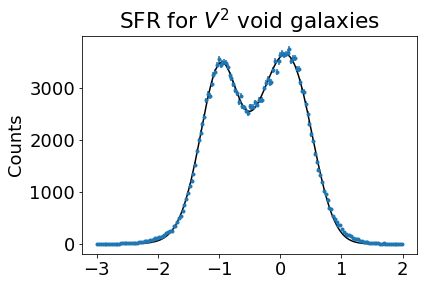

[ 4.47492951e+03  4.72783278e-01  7.49852713e-01 -2.23637352e+00
  2.08704528e+03 -8.08764751e-01  3.88837428e-01 -1.25057068e+00] [8.65573453e+01 1.08007385e-02 3.02973350e-02 1.62695876e-01
 8.47231939e+01 9.89859935e-03 8.81062383e-03 1.06168629e-01]


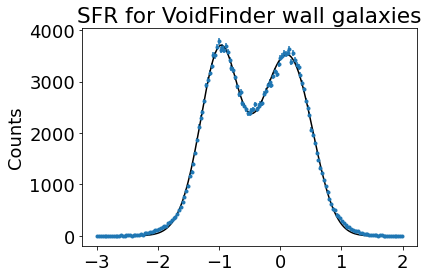

[ 2.44753715e+03 -7.99398551e-01  3.91800795e-01 -1.22616824e+00
  4.09049209e+03  4.70178328e-01  6.83316386e-01 -1.95256844e+00] [7.35689357e+01 8.31140148e-03 7.21357646e-03 9.99996944e-02
 7.40851147e+01 1.27501872e-02 2.91321756e-02 1.58888423e-01]


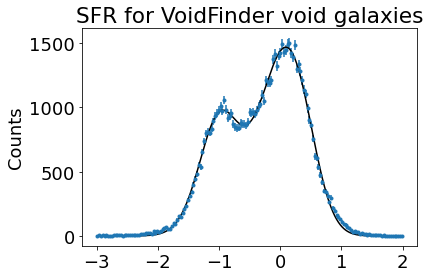

[ 6.26687805e+02 -8.28947524e-01  3.81249067e-01 -9.79443696e-01
  1.63966033e+03  4.40641852e-01  6.48529625e-01 -1.86026119e+00] [4.76826190e+01 3.11000444e-02 2.21429782e-02 2.95069907e-01
 4.78641610e+01 1.96508385e-02 4.40757394e-02 2.39937103e-01]


In [20]:
# a, mua, sga, askew, b, mub, sgb, bskew

SFR_bins = np.linspace(-3, 2, 170)

#print("wall_v2")
k = bin_data(SFR[wall_v2], bins_=SFR_bins)
x, poiss_err = k[0], k[2]
SFR_V2_wall_fit = fit_bimodal(char_=SFR,
                              class_=wall_v2,
                              bins=SFR_bins, 
                              err=poiss_err, 
                              p0_=[4000, 0.5, 0.75, -2.25, 2000, -0.75, 0.5, -1.5], 
                              label='SFR for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(SFR[void_v2], bins_=SFR_bins)
x, poiss_err = k[0], k[2]
SFR_V2_void_fit = fit_bimodal(char_=SFR,
                              class_=void_v2,
                              bins=SFR_bins, 
                              err=poiss_err, 
                              label='SFR for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(SFR[wall_vf], bins_=SFR_bins)
x, poiss_err = k[0], k[2]
SFR_VF_wall_fit = fit_bimodal(char_=SFR,
                              class_=wall_vf,
                              bins=SFR_bins, 
                              err=poiss_err, 
                              p0_=[2000, -1.5, 1.3, 1, 2000, 0.7, 1, 1], 
                              label='SFR for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(SFR[void_vf], bins_=SFR_bins)
x, poiss_err = k[0], k[2]
SFR_VF_void_fit = fit_bimodal(char_=SFR,
                              class_=void_vf,
                              bins=SFR_bins, 
                              err=poiss_err,
                              p0_=[2000,  -1.5,  1.3, 1, 2000, 0.7, 1, 1], 
                              label='SFR for VoidFinder void galaxies')

## sSFR means

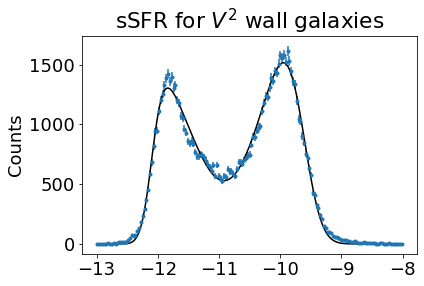

[ 1.52129213e+03 -9.62811309e+00  6.43149851e-01 -2.63950355e+00
  1.17939284e+03 -1.20928307e+01  6.43395772e-01  4.44178581e+00] [2.07467703e+01 7.63548738e-03 1.75318633e-02 1.65526419e-01
 2.06954630e+01 5.11755287e-03 1.76251385e-02 2.93351317e-01]


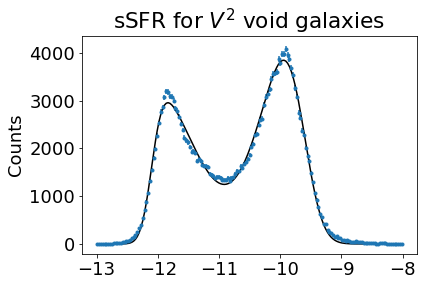

[ 3.76545362e+03 -9.62994875e+00  6.09001259e-01 -2.33917536e+00
  2.78827490e+03 -1.20952265e+01  6.74607512e-01  4.65689467e+00] [4.06786228e+01 6.72048910e-03 1.37560534e-02 1.22585426e-01
 4.11599254e+01 4.43986415e-03 1.57679940e-02 2.65065096e-01]


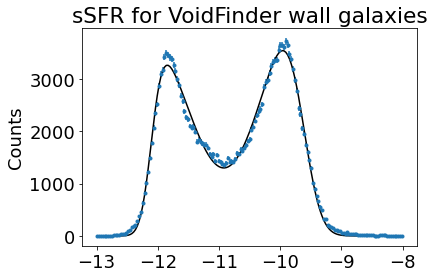

[ 3.61034304e+03 -9.63327539e+00  6.57089625e-01 -2.69955606e+00
  2.92040753e+03 -1.21004571e+01  6.35768833e-01  4.35667469e+00] [4.48410171e+01 6.84089452e-03 1.61886212e-02 1.51858429e-01
 4.45455053e+01 4.35906001e-03 1.50046882e-02 2.44723708e-01]


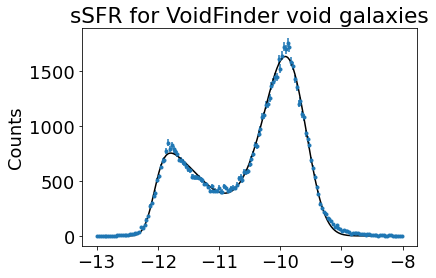

[ 1.46645695e+03 -9.63005965e+00  5.21611439e-01 -1.79463766e+00
  8.00659553e+02 -1.20547533e+01  7.79850678e-01  5.80919620e+00] [1.63316410e+01 8.03592375e-03 1.26685895e-02 1.05322355e-01
 1.71593883e+01 6.17262690e-03 2.59861372e-02 4.83127559e-01]


In [21]:
# a, mua, sga, askew, b, mub, sgb, bskew

#print("wall_v2")
k = bin_data(sSFR[wall_v2], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_V2_wall_fit = fit_bimodal(char_=sSFR,
                               class_=wall_v2,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[1800, -9.6, 0.7, -3, 1300, -12.1, 0.6, 4], 
                               label='sSFR for $V^2$ wall galaxies')


#print("\n void_v2")
k = bin_data(sSFR[void_v2], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_V2_void_fit = fit_bimodal(char_=sSFR,
                               class_=void_v2,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[2000, -9.8, 1.3, 1, 2000, -11.9, 1, 1], 
                               label='sSFR for $V^2$ void galaxies')


#print("\n wall_vf")
k = bin_data(sSFR[wall_vf], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_VF_wall_fit = fit_bimodal(char_=sSFR,
                               class_=wall_vf,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1], 
                               label='sSFR for VoidFinder wall galaxies')


#print("\n void_vf")
k = bin_data(sSFR[void_vf], bins_=np.linspace(-13,-8, 170))
x, poiss_err = k[0], k[2]
sSFR_VF_void_fit = fit_bimodal(char_=sSFR,
                               class_=void_vf,
                               bins=np.linspace(-13,-8, 170), 
                               err=poiss_err,
                               p0_=[ 2000,  -9.8,  1.3, 1,2000,-11.5,1,1], 
                               label='sSFR for VoidFinder void galaxies')

# Extract the mean and the error in the mean from the fit results

### Calculate averages and medians

In [8]:
def remove_nan(array):
    '''
    Remove both nan and inf values from array
    '''
    #return array[np.logical_not(np.isnan(array))]
    return array[np.isfinite(array)]

In [9]:
def stat(char_, voidfinder=False):
    '''
    PARAMETERS
    ==========
    char_ : 
        array with galaxy properties, e.g., Mstar
    
    voidfinder : boolean
        True if we want to calculate the statistics of VoidFinder data and not V2 data
    
    
    note 1 : shifts are taken as (void - wall)
    
    note 2 : percent difference are calculated with respect to the wall distribution
    
    
    RETURNS
    =======
    average
    std of average
    average shift
    std of average shift
    percent diff of avg
    median
    median shift
    percent diff of median
    '''
    
    if voidfinder:
        char_void = remove_nan(char_[void_vf])
        char_wall = remove_nan(char_[wall_vf])
        
    else:
        char_void = remove_nan(char_[void_v2])
        char_wall = remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift = avg_wall-avg_void
        
    std_avg_void = np.std(char_void, ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall, ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    mode_wall = stats.mode(char_wall, axis=None)[0][0]
    mode_void = stats.mode(char_void, axis=None)[0][0]
    
    mode_shift = mode_wall-mode_void
    percent_diff_mode = (mode_shift/mode_wall)*100
    
    print('average void : %.4f \pm %.4f' %(avg_void, std_avg_void))
    print('median void : %.4f' %median_void)
    print('average shift w.r.t wall :  %.4f \pm %.4f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : %.2f percent' %(percent_diff_avg))
    print('median shift w.r.t wall: %.4f' %median_shift)
    print('percent difference in median w.r.t wall : %.2f percent' %percent_diff_median)
    print("\n")
    print('average wall :  %.4f \pm %.4f'%(avg_wall, std_avg_wall))
    print('median wall : %.4f' %median_wall)
    print("\n")
    '''
    print('average void : %.3f \pm %.3f' %(avg_void, std_avg_void))
    print('median void : %.3f' %median_void)
    print('average shift w.r.t wall :  %.3f \pm %.3f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : %.1f percent' %(percent_diff_avg))
    print('median shift w.r.t wall: %.3f' %median_shift)
    print('percent difference in median w.r.t wall : %.1f percent' %percent_diff_median)
    print("\n")
    print('average wall :  %.3f \pm %.3f'%(avg_wall, std_avg_wall))
    print('median wall : %.3f' %median_wall)
    print("\n")
    '''
#     print('mode void : ', mode_void)
#     print('mode wall : ', mode_wall)
#     print('percent difference in mode w.r.t wall : ', percent_diff_mode)

In [10]:
print("\t \tStellar Mass \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(Mstar_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(Mstar_NSA)
print("----------------------------------------------- \n")

print("\t \tAbsolute Magnitude \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(rabsmag_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(rabsmag_NSA)
print("----------------------------------------------- \n")

print("\t \tu-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(u_r_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(u_r_NSA)
print("----------------------------------------------- \n")

print("\t \tg-r \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(g_r_NSA, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(g_r_NSA)
print("----------------------------------------------- \n")

print("\t \tStar formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(SFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(SFR)
print("----------------------------------------------- \n")

print("\t \tSpecific Star Formation Rate \n")
print("--------------------VOIDFINDER--------------------------- \n")
stat(sSFR, voidfinder=True)
print("\n----------------------V2------------------------- \n")
stat(sSFR)
print("----------------------------------------------- \n")

	 	Stellar Mass 

--------------------VOIDFINDER--------------------------- 

average void : 9.7865 \pm 0.0022
median void : 9.9101
average shift w.r.t wall :  0.2055 \pm 0.0024
percent difference in avg w.r.t wall : 2.06 percent
median shift w.r.t wall: 0.1642
percent difference in median w.r.t wall : 1.63 percent


average wall :  9.9920 \pm 0.0011
median wall : 10.0744



----------------------V2------------------------- 

average void : 9.9274 \pm 0.0012
median void : 10.0249
average shift w.r.t wall :  0.0376 \pm 0.0022
percent difference in avg w.r.t wall : 0.38 percent
median shift w.r.t wall: 0.0429
percent difference in median w.r.t wall : 0.43 percent


average wall :  9.9650 \pm 0.0019
median wall : 10.0678


----------------------------------------------- 

	 	Absolute Magnitude 

--------------------VOIDFINDER--------------------------- 

average void : -19.6192 \pm 0.0044
median void : -19.8372
average shift w.r.t wall :  -0.3591 \pm 0.0049
percent difference in avg w.r.t

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_31829/4259382079.py:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_wall = stats.mode(char_wall, axis=None)[0][0]
/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_31829/4259382079.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

average void : 1.7632 \pm 0.0018
median void : 1.7301
average shift w.r.t wall :  0.1733 \pm 0.0021
percent difference in avg w.r.t wall : 8.95 percent
median shift w.r.t wall: 0.2587
percent difference in median w.r.t wall : 13.01 percent


average wall :  1.9365 \pm 0.0011
median wall : 1.9888



----------------------V2------------------------- 

average void : 1.8875 \pm 0.0011
median void : 1.9162
average shift w.r.t wall :  0.0251 \pm 0.0020
percent difference in avg w.r.t wall : 1.31 percent
median shift w.r.t wall: 0.0338
percent difference in median w.r.t wall : 1.73 percent


average wall :  1.9126 \pm 0.0017
median wall : 1.9500


----------------------------------------------- 

	 	g-r 

--------------------VOIDFINDER--------------------------- 

average void : 0.5614 \pm 0.0007
median void : 0.5729
average shift w.r.t wall :  0.0540 \pm 0.0008
percent difference in avg w.r.t wall : 8.77 percent
median shift w.r.t wall: 0.0855
percent difference in median w.r.t wall : 12.98